<a href="https://colab.research.google.com/github/thaliaslsblla27-cpu/thalia_DPL/blob/main/DL_Per3_41236805_THALIA_SALSABILLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -------------------------------
# Tugas 1: Bangun VAE untuk Fashion-MNIST
# -------------------------------

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, losses, optimizers
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load dan Preproses Data
# -------------------------------
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()

# Konversi ke float32 dan normalisasi ke [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Tambahkan padding menjadi 32x32
x_train = np.pad(x_train, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
x_test = np.pad(x_test, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)

# Tambahkan channel grayscale (32, 32, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("Data shape:", x_train.shape, x_test.shape)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Data shape: (60000, 32, 32, 1) (10000, 32, 32, 1)


In [2]:
# -------------------------------
# 2. Bangun Encoder
# -------------------------------
latent_dim = 2

encoder_input = layers.Input(shape=(32, 32, 1), name="encoder_input")
x = layers.Conv2D(32, (3, 3), strides=2, padding="same", activation="relu")(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2D(128, (3, 3), strides=2, padding="same", activation="relu")(x)
shape_before_flattening = x.shape[1:]  # simpan shape untuk decoder
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Sampling layer dengan reparameterization trick
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Sampling()([z_mean, z_log_var])
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
# -------------------------------
# 3. Bangun Decoder
# -------------------------------
decoder_input = layers.Input(shape=(latent_dim,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening), activation="relu")(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same", activation="relu")(x)
decoder_output = layers.Conv2D(1, (3, 3), padding="same", activation="sigmoid")(x)
decoder = models.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# -------------------------------
# 4. Bangun VAE dengan Custom Training Loop
# -------------------------------
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            # Reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

# Instansiasi dan kompilasi VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=optimizers.Adam())

In [5]:
# -------------------------------
# 5. Latih Model
# -------------------------------
# Re-compile VAE with a dummy loss as the original compile was missing it
# Correcting the loss argument to match the multiple outputs of VAE.call() for validation.
vae.compile(optimizer=optimizers.Adam(), loss=[None, None, tf.keras.losses.MeanSquaredError()])
history = vae.fit(x_train, epochs=15, batch_size=128, validation_data=(x_test, x_test))



Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - kl_loss: 4.2948 - reconstruction_loss: 385.1849 - total_loss: 389.4798 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - kl_loss: 5.9718 - reconstruction_loss: 265.1147 - total_loss: 271.0865 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - kl_loss: 5.9799 - reconstruction_loss: 261.3598 - total_loss: 267.3397 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - kl_loss: 6.0440 - reconstruction_loss: 259.3488 - total_loss: 265.3928 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - kl_loss: 6.0915 - reconstruction_loss: 257.9387 - total_loss: 264.03

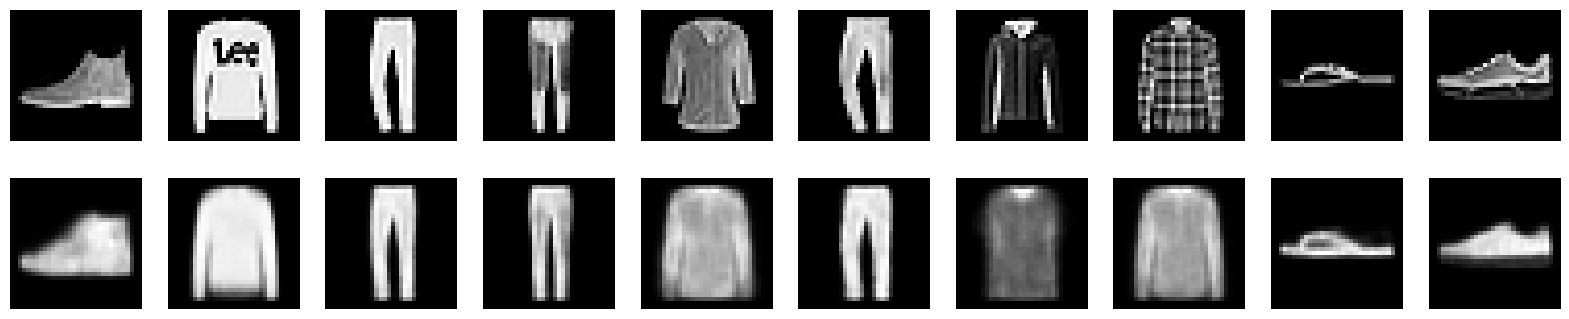

In [6]:
# -------------------------------
# 6. Visualisasi Rekonstruksi
# -------------------------------
def plot_reconstructions(model, data, n=10):
    _, _, reconstructions = model(data[:n])
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Asli
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i].squeeze(), cmap="gray")
        plt.axis("off")
        # Rekonstruksi
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i].numpy().squeeze(), cmap="gray") # Fixed line
        plt.axis("off")
    plt.show()

plot_reconstructions(vae, x_test)

# -------------------------------
# 7. Simpan Model (opsional)
# -------------------------------
encoder.save("vae_fashion_encoder.h5")
decoder.save("vae_fashion_decoder.h5")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


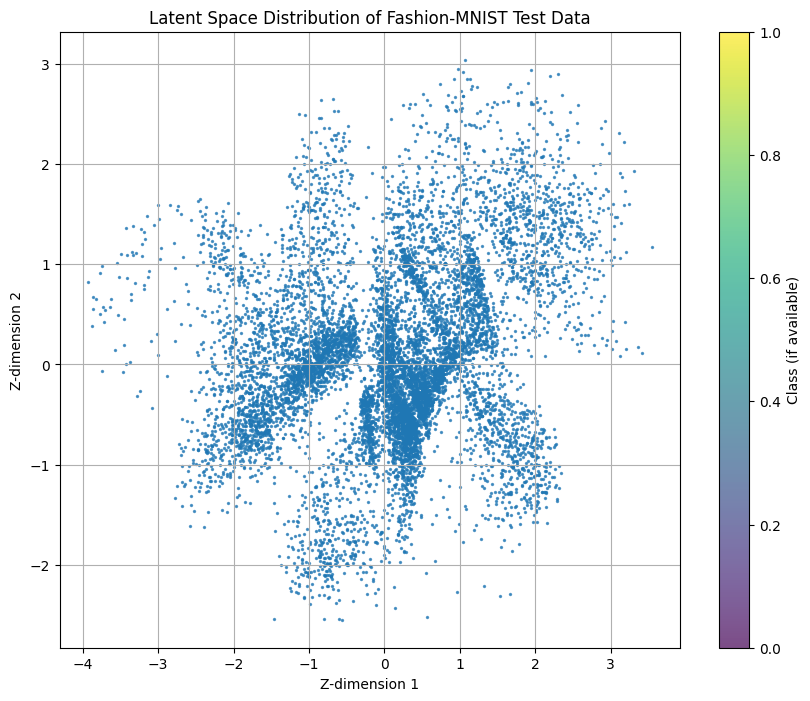

In [7]:
import matplotlib.pyplot as plt

# Asumsi z_means sudah dihitung dan tersedia dari encoder(x_test)
z_means, _, _ = vae.encoder.predict(x_test)

plt.figure(figsize=(10, 8))
plt.scatter(z_means[:, 0], z_means[:, 1], alpha=0.7, s=2)
plt.xlabel("Z-dimension 1")
plt.ylabel("Z-dimension 2")
plt.title("Latent Space Distribution of Fashion-MNIST Test Data")
plt.colorbar(label="Class (if available)") # Label ini akan tetap muncul, namun tidak ada warna berdasarkan kelas karena tidak ada label kelas yang dimuat.
plt.grid(True)
plt.show()

In [8]:
(_, y_train), (_, y_test) = keras.datasets.fashion_mnist.load_data()
print("y_test successfully loaded with shape:", y_test.shape)
print("First 10 y_test labels:", y_test[:10])

y_test successfully loaded with shape: (10000,)
First 10 y_test labels: [9 2 1 1 6 1 4 6 5 7]


Generate Latent Space Means for Test Data

In [9]:
print("Shape of z_means:", z_means.shape)
print("First 5 elements of z_means:\n", z_means[:5])

Shape of z_means: (10000, 2)
First 5 elements of z_means:
 [[-1.225844    0.11934721]
 [ 0.42165032 -0.73690856]
 [ 2.6448903   0.8101621 ]
 [ 1.837926    1.4986529 ]
 [ 0.00895545 -0.38769236]]


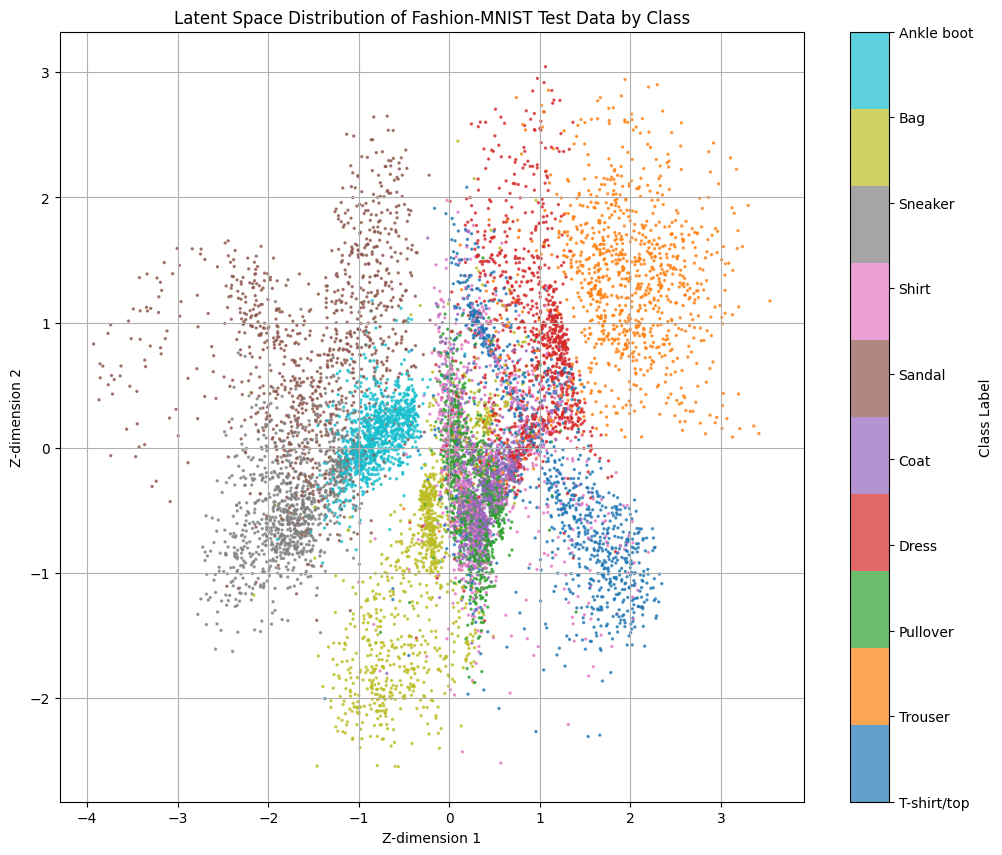

In [10]:
fashion_mnist_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

plt.figure(figsize=(12, 10))
scatter = plt.scatter(z_means[:, 0], z_means[:, 1], c=y_test, cmap="tab10", alpha=0.7, s=2)
plt.xlabel("Z-dimension 1")
plt.ylabel("Z-dimension 2")
plt.title("Latent Space Distribution of Fashion-MNIST Test Data by Class")
cbar = plt.colorbar(scatter)
cbar.set_label("Class Label")
cbar.set_ticks(range(10))
cbar.set_ticklabels(fashion_mnist_labels)
plt.grid(True)
plt.show()


--- [3. Latent Space Arithmetic] Interpolasi ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


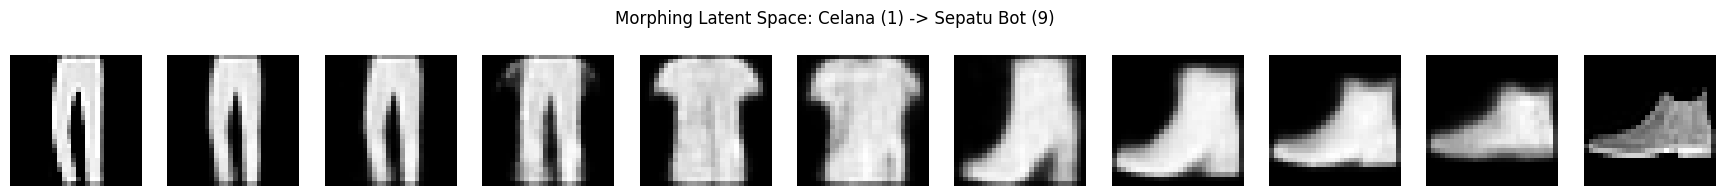

In [23]:
print("\n--- [3. Latent Space Arithmetic] Interpolasi ---")

def plot_images(images, title="", n_row=1):
    n = len(images)
    plt.figure(figsize=(2 * n, 2 * n_row))
    plt.suptitle(title, y=1.05)
    for i, image in enumerate(images):
        ax = plt.subplot(n_row, n // n_row, i + 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.axis("off")
    plt.show()

# Pilih dua gambar untuk interpolasi (misal: Trouser dan Ankle boot)
idx_A = np.where(y_test == 1)[0][0] # Trouser (Celana)
idx_B = np.where(y_test == 9)[0][0] # Ankle Boot (Sepatu Bot)

img_A = x_test[idx_A]
img_B = x_test[idx_B]

# Encode kedua gambar
z_A, _, _ = encoder.predict(np.expand_dims(img_A, axis=0))
z_B, _, _ = encoder.predict(np.expand_dims(img_B, axis=0))

# Interpolasi Linier
n_steps = 9
interpolated_images = []
alphas = np.linspace(0, 1, n_steps)

for alpha in alphas:
    z_interp = (1 - alpha) * z_A + alpha * z_B
    img_interp = decoder.predict(z_interp)
    interpolated_images.append(img_interp[0])

# Visualisasi Hasil
original_images = [img_A] + interpolated_images + [img_B]
plot_images(original_images, title=f"Morphing Latent Space: Celana ({y_test[idx_A]}) -> Sepatu Bot ({y_test[idx_B]})", n_row=1)

--- 1. Memuat dan Memproses Data Fashion-MNIST ---

--- 3. Melatih Model (VAE dan AE Biasa) ---
Melatih VAE selama 50 epochs...
Melatih AE Biasa selama 50 epochs...

--- 5. Visualisasi Perbandingan Rekonstruksi ---

Menghitung rekonstruksi untuk 10 sampel...


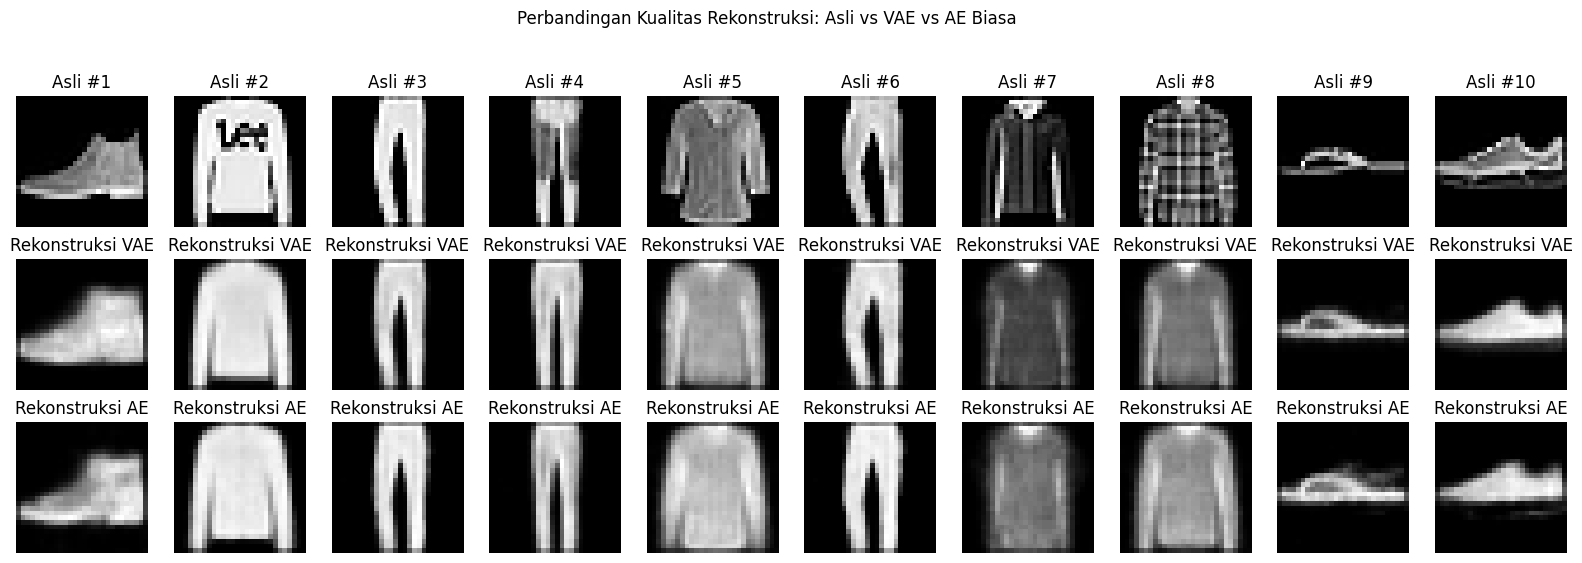

In [25]:
# ----------------------------------------------------
# PERBANDINGAN REKONSTRUKSI: VAE vs AUTOENCODER BIASA
# ----------------------------------------------------

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, losses, optimizers
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load dan Preproses Data
# -------------------------------
print("--- 1. Memuat dan Memproses Data Fashion-MNIST ---")
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalisasi ke [0, 1] dan Reshape (28, 28, 1)
x_train = np.expand_dims(x_train.astype("float32") / 255.0, -1)
x_test = np.expand_dims(x_test.astype("float32") / 255.0, -1)

# Parameter
latent_dim = 2
input_shape = (28, 28, 1)

# Definisikan nama kelas Fashion-MNIST
fmnist_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# -------------------------------
# 2. Definisi Arsitektur Model
# -------------------------------

# Kelas Sampling (Reparameterization Trick untuk VAE)
class Sampling(layers.Layer):
    """Menggunakan (z_mean, z_log_var) untuk mengambil sampel z dari distribusi Gaussian"""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# ENCODER (Digunakan untuk VAE dan AE)
def create_encoder(input_shape, latent_dim, use_vae=True):
    encoder_inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)

    if use_vae:
        # VAE output: mean dan log_var
        z_mean = layers.Dense(latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
        z = Sampling()([z_mean, z_log_var])
        return keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder_vae")
    else:
        # AE output: z tunggal
        z = layers.Dense(latent_dim, name="z")(x)
        return keras.Model(encoder_inputs, z, name="encoder_ae")

# DECODER (Digunakan untuk VAE dan AE)
def create_decoder(latent_dim):
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

# Model VAE (dengan Custom Train Step untuk Loss)
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        # Inisialisasi Metrik
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Reconstruction Loss (Binary Cross-Entropy)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2))
            )

            # KL Divergence Loss
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# --- Inisialisasi Model ---

# VAE
encoder_vae = create_encoder(input_shape, latent_dim, use_vae=True)
decoder_vae = create_decoder(latent_dim)
vae = VAE(encoder_vae, decoder_vae)

# Autoencoder (AE) Biasa
encoder_ae = create_encoder(input_shape, latent_dim, use_vae=False)
decoder_ae = create_decoder(latent_dim)
ae_inputs = keras.Input(shape=input_shape)
z_ae = encoder_ae(ae_inputs)
ae_outputs = decoder_ae(z_ae)
ae = keras.Model(ae_inputs, ae_outputs, name="autoencoder")


# -------------------------------
# 3. Kompilasi dan Latih Model
# -------------------------------

print("\n--- 3. Melatih Model (VAE dan AE Biasa) ---")
epochs = 50
batch_size = 128

# Latih VAE
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
print(f"Melatih VAE selama {epochs} epochs...")
vae.fit(x_train, epochs=epochs, batch_size=batch_size, verbose=0)

# Latih AE Biasa
ae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
           loss='mse') # AE biasa menggunakan MSE untuk rekonstruksi
print(f"Melatih AE Biasa selama {epochs} epochs...")
ae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, verbose=0)


# -------------------------------
# 4. Fungsi Plotting
# -------------------------------

# Fungsi Perbandingan Utama: Asli vs VAE vs AE
def plot_comparison(vae_model, ae_model, data, n=10):
    """
    Membandingkan rekonstruksi Asli, VAE, dan AE biasa
    pada 10 sampel data uji pertama.
    """

    print(f"\nMenghitung rekonstruksi untuk {n} sampel...")

    # 1. Rekonstruksi VAE
    # Ambil titik z (sampling) dari VAE encoder
    _, _, z_vae = vae_model.encoder.predict(data[:n], verbose=0)
    reconstructions_vae = vae_model.decoder.predict(z_vae, verbose=0)

    # 2. Rekonstruksi AE
    # Ambil titik z tunggal dari AE encoder
    z_ae = encoder_ae.predict(data[:n], verbose=0)
    reconstructions_ae = decoder_ae.predict(z_ae, verbose=0)

    # Plot Hasil
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Baris 1: Gambar Asli
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(data[i].reshape(28, 28), cmap="gray")
        ax.set_title(f"Asli #{i+1}")
        ax.axis("off")

        # Baris 2: Rekonstruksi VAE
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(reconstructions_vae[i].reshape(28, 28), cmap="gray")
        ax.set_title("Rekonstruksi VAE")
        ax.axis("off")

        # Baris 3: Rekonstruksi AE Biasa
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(reconstructions_ae[i].reshape(28, 28), cmap="gray")
        ax.set_title("Rekonstruksi AE")
        ax.axis("off")

    plt.suptitle("Perbandingan Kualitas Rekonstruksi: Asli vs VAE vs AE Biasa", y=1.02)
    plt.show()


# -------------------------------
# 5. EKSEKUSI PERBANDINGAN
# -------------------------------

print("\n--- 5. Visualisasi Perbandingan Rekonstruksi ---")
plot_comparison(vae, ae, x_test, n=10) # Bandingkan 10 gambar pertama dari data uji